# Import Libraries

In [29]:
%%capture
!pip install pyDOE

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.utils.checkpoint import checkpoint

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# Sine Activation

In [31]:
class SineActivation(nn.Module):
    """ Sine Activation function. """
    def forward(self, input):
            return torch.sin(input)

# Physics Informed Neural Network

In [32]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 2D Gross-Pitaevskii equation (GPE).
    This PINN learns the wave function 'u' and minimizes the energy functional.

    Attributes
    ----------
    layers : nn.ModuleList
        List of neural network layers.
    ub : torch.Tensor
        Upper bound for input normalization.
    lb : torch.Tensor
        Lower bound for input normalization.
    hbar : torch.nn.Parameter
        Planck's constant, scaled to 1.0.
    m : torch.nn.Parameter
        Particle mass, scaled to 1.0.
    g : torch.nn.Parameter
        Interaction strength, initialized but learned over the interval [0, 500].
    """

    def __init__(self, layers, ub, lb, hbar=1.0, m=1.0):
        """
        Initializes the PINN model with given layer sizes and boundary conditions.

        Parameters
        ----------
        layers : list
            List of integers specifying the number of units in each layer.
        ub : list or numpy.ndarray
            Upper bounds of the input domain for feature normalization.
        lb : list or numpy.ndarray
            Lower bounds of the input domain for feature normalization.
        hbar : float, optional
            Planck's constant, in J⋅Hz^{−1}, scaled to 1.0.
        m : float
            Particle mass, scaled to 1.0.
        g : float
            Interaction strength, over the range of [0,500].
        """
        super(GrossPitaevskiiPINN, self).__init__()

        # Feature scaling
        self.ub = torch.tensor(ub, dtype=torch.float32, device='cuda')
        self.lb = torch.tensor(lb, dtype=torch.float32, device='cuda')

        # Physics parameters
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed

        # Learnable interaction strength 'g', varying over [0, 500]
        self.g = nn.Parameter(torch.tensor(1.0, device='cuda'))  # Learnable interaction strength, initialized to 1.0

        # MSE and MAE loss functions
        self.loss_function = nn.MSELoss(reduction='mean')
        self.l1loss_function = nn.L1Loss(reduction='mean')

        # Define network layers
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(SineActivation())
        self.activation = SineActivation()  # Final activation layer
        self.init_weights()

    def init_weights(self):
        """ Initialize weights using Xavier initialization. """
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                #nn.init.constant_(m.bias, 1e-2)  # Perturb bias from zero

    def forward(self, x):
        """
        Forward pass through the network. Applies input scaling and passes through layers.
        Parameters
        ----------
        x : torch.Tensor
            Input spatial coordinates.
        g : float
            Interaction strength (learned over [0, 500]).
        """

        # Ensure lb and ub are broadcastable to the shape of x
        lb = self.lb.view(1, -1)  # Reshape lb to (1, num_features)
        ub = self.ub.view(1, -1)  # Reshape ub to (1, num_features)

        # Normalize the inputs
        x = (x - lb) / (ub - lb)

        # Use gradient checkpointing in layers to save memory
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear):  # Apply checkpointing to linear layers
                x = checkpoint(layer, x, use_reentrant=False)
            else:
                x = layer(x)

        # Normalize to L² norm = 1
        x = x / torch.sqrt(torch.sum(x ** 2))

        return x

    def test(self, X_u_test_tensor):
        """
        Tests the model on the test data and computes the relative L2 norm of the error.

        Parameters
        ----------
        X_u_test_tensor : torch.Tensor
            Input tensor for the test data.

        Returns
        -------
        error_vec : torch.Tensor
            The relative L2 norm of the error.
        u_pred : numpy.ndarray
            The predicted output reshaped as a 2D array.
        ground_truth_solution : torch.Tensor
            The ground truth solution.
        """

        # Ensure input tensors requires gradients
        X_u_test_tensor.requires_grad_(True)

        # Use mixed precision during inference
        with torch.cuda.amp.autocast():
            u_pred = self.forward(X_u_test_tensor)

        # Compute the residual through the PDE loss
        _, pde_residual, _ = self.pde_loss(X_u_test_tensor, u_pred)

        # Reshape the predicted output to a 2D array
        num_grid_pts = int(torch.sqrt(torch.tensor(X_u_test_tensor.shape[0])))
        u_pred_reshaped = u_pred.cpu().detach().numpy().reshape((num_grid_pts, num_grid_pts), order='F')

        return pde_residual, u_pred_reshaped

    def data_loss(self, x_bc, y_bc):
        """
        Computes the data loss (MSE) at the boundary.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition output (true) values.

        Returns
        -------
        torch.Tensor
            Scaled mean squared error (MSE) loss for boundary conditions.
        """

        # Predict values for boundary points
        u_pred = self.forward(x_bc)

        # Ensure boundary conditions are enforced by making y_bc a zero tensor
        y_bc = torch.zeros_like(u_pred)

        # Adaptive scaling for boundary loss
        bc_loss = torch.mean((u_pred - y_bc) ** 2)

        return bc_loss

    def trial_data_loss(self, xy, u_pred):
        # Improve through (random) sampling method similar to Latin Hypercube Sampling
        N_train = 1000
        xy = np.random.rand(N_train, 2)
        xy = torch.tensor(xy, dtype=torch.float32, requires_grad=True).to(device)

        x = xy[:, 0]
        y = xy[:, 1]
        return (1 - x) * (1 - y) * x * y * u_pred  # Ensures u=0 at the boundary

    def riesz_loss(self, predictions, inputs):
        """
        Computes the Riesz energy loss for the 2D Gross-Pitaevskii equation.

        Energy functional: E(u) = (1/2) ∫_Ω |∇u|² + V(x)|u|² + (η/2) |u|⁴ dx

        where:
        - u is the predicted solution,
        - V(x) is the potential function,
        - η is a constant parameter,
        - ∇u represents the gradient of u.

        Parameters
        ----------
        predictions : torch.Tensor
            Model predictions.
        inputs : torch.Tensor
            Input points.

        Returns
        -------
        torch.Tensor
            Riesz energy loss.
        """

        u_normalized = predictions / torch.sqrt(torch.sum(predictions ** 2)) # Normalize to L^2 norm = 1

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]

        laplacian_term = 0.5 * torch.mean(gradients ** 2)  # Kinetic term
        V = self.compute_potential(inputs).unsqueeze(1)  # Potential term
        interaction_term = 0.5 * self.g * torch.mean(u_normalized ** 4)  # Interaction term

        riesz_energy = laplacian_term + torch.mean(V * u_normalized ** 2) + interaction_term

        # Potential V(x)
        #V = self.compute_potential(inputs).unsqueeze(1)

        # Energy functional (to minimize)
        #riesz_energy = torch.mean(gradients ** 2 + V * u_normalized ** 2 + 0.5 * self.g * u_normalized ** 4)

        # Regularize to avoid trivial zero solution (added on 09/29/24)
        #epsilon = 1e-4  # Small regularization coefficient
        #riesz_energy += epsilon * torch.mean(torch.abs(u))

        return riesz_energy

    def pde_loss(self, inputs, predictions):
        """
        Computes the PDE loss for the 2D Gross-Pitaevskii equation:

        -∇²u + V(x)u + η|u|²u - λu = 0

        The loss is based on the residual of the equation after solving for `u` and computing
        the smallest eigenvalue `λ` using the energy functional.

        Parameters
        ----------
        inputs : torch.Tensor
            Input points (x, y).
        predictions : torch.Tensor
            Predicted output from the network, representing the wave function ψ.

        Returns
        -------
        pde_loss: torch.Tensor
            Constant representing the Gross-Pitaevskii PDE loss.
        pde_residual: torch.Tensor
            Tensor representing the residual of the Gross-Pitaevskii PDE.
        lambda_pde: torch.Tensor
            Constant representing the smallest eigenvalue of the Gross-Pitaevskii PDE.
        """

        u = predictions / torch.sqrt(torch.sum(predictions ** 2)) # Normalize to L^2 norm = 1

        # Compute gradients
        u_x = torch.autograd.grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Second derivatives of the Laplacian (∇²u)
        u_xx = torch.autograd.grad(u_x[0, :], inputs, grad_outputs=torch.ones_like(u_x[0, :]), create_graph=True)[0][0,:]
        u_yy = torch.autograd.grad(u_x[1, :], inputs, grad_outputs=torch.ones_like(u_x[1, :]), create_graph=True)[0][1,:]
        laplacian_u = u_xx + u_yy

        # Compute λ directly from the energy functional as the average energy per unit u.
        lambda_pde = torch.mean(laplacian_u + self.g * torch.abs(u ** 2) * u) / torch.mean(u ** 2) #  λ is the smallest eigenvalue of the system

        # Residual of the PDE (Gross-Pitaevskii equation)
        pde_residual = -laplacian_u + self.g * torch.abs(u ** 2) * u - (lambda_pde * u)

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Regularization term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to
        # avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)  # Add small constant to avoid division by zero

        # Regularization term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Regularization term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        c = 1.0  # Tunable
        L_drive = torch.exp(-lambda_pde + c)

        # PDE loss as the residual plus regularization
        pde_loss = torch.mean(pde_residual ** 2) + L_f + L_lambda #+ L_drive
        #pde_loss = torch.mean(pde_residual ** 2)

        return pde_loss, pde_residual, lambda_pde

    def loss(self, x_bc, y_bc, x_to_train_f, current_epoch, g):
        """
        Computes the total loss combining BC loss, PDE loss (Gross Pitaevskii), and Riesz loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition true values.
        x_to_train_f : torch.Tensor
            Input points for PDE training.
        current_epoch : int
        The current training epoch to control the boundary condition scaling over time.

        Returns
        -------
        torch.Tensor
            Total loss combining BC, PDE, and Riesz losses.
        """

        # Clamp g to be within the desired range [0, 500]
        self.g.data = torch.clamp(torch.tensor(g, device='cuda'), 1000, 1000)

        # Data loss at boundary
        data_loss = self.data_loss(x_bc, y_bc)

        predictions = self.forward(x_to_train_f)

        # TODO: Better way to form xy? Pass into PINN constructor or individual method?
        data_loss_2 = self.trial_data_loss(X_u_train,predictions)

        # PDE loss
        loss_pde, _, _ = self.pde_loss(x_to_train_f, predictions)

        # Riesz energy loss
        loss_riesz = self.riesz_loss(predictions, x_to_train_f) # Script E in paper

        # Add a norm regularization term to prevent trivial solutions
        #norm_constraint = 1e-3 * torch.mean(predictions ** 2)  # Penalize zero solutions

        total_loss = data_loss + loss_pde + loss_riesz #+ norm_constraint
        total_loss_2 = data_loss_2 + loss_pde + loss_riesz
        return total_loss

    def compute_potential(self, inputs, V0=1.0, x0=np.pi / 2, y0=np.pi / 2, sigma=0.5):
        """
        Compute the Gaussian potential V(x,y) over the domain.

        V(x,y) = V0 * exp(-((x - x0)^2 + (y - y0)^2) / (2 * sigma^2))

        Parameters
        ----------
        inputs : torch.Tensor
            The input spatial coordinates (x, y) as a 2D tensor.
        V0 : float, optional
            Amplitude of the Gaussian potential (default is 1.0).
        x0 : float, optional
            Center of the Gaussian in the x-direction (default is π/2).
        y0 : float, optional
            Center of the Gaussian in the y-direction (default is π/2).
        sigma : float, optional
            Width (spread) of the Gaussian (default is 0.5).

        Returns
        -------
        V : torch.Tensor
            The potential evaluated at each input point.
        """
        x = inputs[:, 0]
        y = inputs[:, 1]

        # Gaussian potential
        V = V0 * torch.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
        #V = V0 * torch.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))

        #omega = 1.0
        # Harmonic potential
        #V = 0.5 * omega ** 2 * (x ** 2 + y ** 2)
        return V

    def get_ground_state(self, x):
        """
        Returns the ground state (u vector) and its corresponding energy (lambda scalar).

        Parameters
        ----------
        x : torch.Tensor
            Input points to evaluate the wave function.

        Returns
        -------
        u : torch.Tensor
            Ground state wave function values.
        lambda_min : float
            Corresponding smallest eigenvalue value (energy).
        """
        # Forward pass through the network
        u = self.forward(x)
        u_normalized = u / torch.sqrt(torch.sum(u ** 2)) # Normalize to L^2 norm = 1

        # Compute the smallest energy (λ_*) from the pde_loss method
        _, _, lambda_min = self.pde_loss(x, u_normalized)

        return u_normalized, lambda_min.item()

# Create Grid

In [33]:
def create_grid(num_grid_pts=256, n_dim=2):
    """
    Create an n-dimensional grid of points as a NumPy array in a memory-efficient way.

    Parameters
    ----------
    num_grid_pts : int, optional
        The number of grid points along each dimension (default is 256).
    n_dim : int, optional
        The number of dimensions (default is 2).

    Returns
    -------
    grid : np.ndarray
        n-dimensional grid points as a NumPy array.
    axis_points : list of np.ndarray
        List of 1D arrays of points for every dimension.
    """
    # Form 1D arrays for every dimension
    axis_points = [np.linspace(0, np.pi, num_grid_pts) for _ in range(n_dim)]

    # Generate a meshgrid up to n_dim
    grids = np.meshgrid(*axis_points, indexing='ij', sparse=False)

    return grids, axis_points

# Prepare Training Data

In [34]:
def prepare_training_data(N_u, N_f, lb, ub, num_grid_pts, X, Y):
    """
    Prepare boundary condition data and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary condition points to select.
    N_f : int
        Number of collocation points for the physics-informed model.
    lb : np.Tensor
        Lower bound of the domain.
    ub : np.Tensor
        Upper bound of the domain.
    num_grid_pts : int
        Number of grid points.
    X : np.Tensor
        X grid of points.
    Y : np.Tensor
        Y grid of points.

    Returns
    -------
    X_f_train : np.Tensor
        Combined collocation points and boundary points as training data.
    X_u_train : np.Tensor
        Selected boundary condition points.
    u_train : np.Tensor
        Corresponding boundary condition values.
    """

    # Extract boundary points and values from all four edges
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_u = np.zeros((num_grid_pts, 1))

    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_u = np.zeros((num_grid_pts, 1))

    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_u = np.zeros((num_grid_pts, 1))

    bottomedge_x = np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    bottomedge_u = np.zeros((num_grid_pts, 1))

    # Combine all edge points
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])

    # Randomly select N_u points from boundary
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    # Select the corresponding training points and u values
    X_u_train = all_X_u_train[idx[0:N_u], :]  # Boundary points (x, t)
    u_train = all_u_train[idx[0:N_u], :]      # Corresponding u values

    # Generate N_f collocation points using Latin Hypercube Sampling
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Generates points in the domain [lb, ub]

    # Combine collocation points with boundary points
    X_f_train = np.vstack((X_f, X_u_train))

    return X_f_train, X_u_train, u_train

# Prepare Test Data

In [35]:
def prepare_test_data(X, Y):
    """
    Prepare test data by flattening the 2D grids and stacking them column-wise.

    Parameters
    ----------
    X : np.ndarray
        2D grid points in the x-dimension as a NumPy array.
    Y : np.ndarray
        2D grid points in the y-dimension as a NumPy array.

    Returns
    -------
    X_u_test : np.ndarray
        Test data prepared by stacking the flattened x and y grids.
    lb : np.ndarray
        Lower bound for the domain (boundary conditions).
    ub : np.ndarray
        Upper bound for the domain (boundary conditions).
    """
    # Flatten the grids and stack them into a 2D array
    X_u_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    # Domain bounds as NumPy arrays
    lb = np.array([0, 0], dtype=np.float32)
    ub = np.array([np.pi, np.pi], dtype=np.float32)

    return X_u_test, lb, ub

# Training PINN Hybrid

In [36]:
def train_pinn_hybrid(model, adam_optimizer, lbfgs_optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs_adam, epochs_lbfgs):
    """
    Hybrid training loop for the PINN model using Adam with mixed precision followed by LBFGS. Plots training error.

    Parameters
    ----------
    model : GrossPitaevskiiPINN
        The PINN model to be trained.
    adam_optimizer : torch.optim.Optimizer
        Adam optimizer for initial training.
    lbfgs_optimizer : torch.optim.Optimizer
        LBFGS optimizer for fine-tuning.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    epochs_adam : int
        Number of epochs for Adam optimization.
    epochs_lbfgs : int
        Number of epochs for LBFGS optimization.
    """

    scaler = torch.amp.GradScaler()  # Mixed precision scaler

    # Initialize lists to track progress
    train_losses = []
    test_losses = []
    test_metrics = []
    steps = []

    # Ensure input tensors have requires_grad=True
    x_bc = x_bc.clone().detach().requires_grad_(True)
    y_bc = y_bc.clone().detach().requires_grad_(True)
    x_to_train_f = x_to_train_f.clone().detach().requires_grad_(True)

    # Adam optimization phase with mixed precision
    for epoch in range(epochs_adam):
        model.train()
        adam_optimizer.zero_grad()

        # Randomly sample g in [0, 500] for each epoch
        g_sample = torch.FloatTensor(1).uniform_(0, 1).to('cuda')

        with torch.amp.autocast('cuda'):
            loss = model.loss(x_bc, y_bc, x_to_train_f, current_epoch=epoch, g=g_sample)

        loss = loss.mean()  # Mean of all losses

        # Gradient clipping - Prevents exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.scale(loss).backward()
        scaler.step(adam_optimizer)
        scaler.update()

        scheduler.step(loss)

        if epoch % 100 == 0:
            train_losses.append(loss.item())

            # Evaluation on test data
            u_pred_test = model(X_u_test_tensor)
            u_pred_test = u_pred_test / torch.sqrt(torch.sum(u_pred_test ** 2))  # Normalize to L² norm = 1

            # Reshape predicted solution
            num_grid_pts = int(np.sqrt(X_u_test_tensor.shape[0]))
            u_pred_test_reshaped = u_pred_test.cpu().detach().numpy().reshape((num_grid_pts, num_grid_pts))

            # Ground Truth (Guess)
            u_true_full_grid = np.exp(-(X**2 + Y**2))
            u_true_full_grid_reshaped = u_true_full_grid.reshape((num_grid_pts, num_grid_pts))

            # Compute the absolute error
            abs_error = np.abs(u_pred_test_reshaped - u_true_full_grid_reshaped)

            # Plot the predicted solution and pass the current epoch
            plot_solution(X_u_test_tensor.detach().cpu().numpy(), u_pred_test_reshaped, epoch)

            # Plot the absolute error and pass the current epoch
            plot_absolute_error(X_u_test_tensor.detach().cpu().numpy(), abs_error, epoch)

            print(f'Epoch {epoch}/{epochs_adam}, Train Loss: {loss.item():.8f}')

    # LBFGS optimization
    def closure():
        lbfgs_optimizer.zero_grad()
        # Use the last sampled g during LBFGS optimization
        loss = model.loss(x_bc, y_bc, x_to_train_f, current_epoch=epochs_adam - 1, g=g_sample)

        loss = loss.sum()
        loss.backward()
        return loss

    for _ in range(epochs_lbfgs):
        lbfgs_optimizer.step(closure)

    print("Training complete.")

    # Plot the training progress after training is done
    plot_training_progress(train_losses, test_losses, test_metrics, steps)

# Energy Progress

In [37]:
def plot_energy_progress(energy_list):
    """
    Plots the energy progress over training.

    Parameters
    ----------
    energy_list : list
        List of energy values recorded during training.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(energy_list, label='Lowest Energy')
    plt.xlabel('Epochs')
    plt.ylabel('Energy')
    plt.title('Lowest Energy Ground State During Training')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Training Progress

In [38]:
def plot_training_progress(train_losses, test_losses, test_metrics, steps):
    """
    Plot the training and test losses, along with the test metric, over the course of training.

    Parameters
    ----------
    train_losses : list
        List of training loss values recorded at each training step.
    test_losses : list
        List of test loss values recorded at each evaluation step.
    test_metrics : list
        List of test metrics (such as error or accuracy) recorded during training.
    steps : list
        List of step numbers corresponding to the recorded losses and metrics.

    Returns
    -------
    None
    """

    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(steps, train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')

    # Plot test loss
    plt.plot(steps, test_losses, label='Test Loss', color='red', linestyle='--', marker='x')

    # Plot test error (or other metrics)
    plt.plot(steps, test_metrics, label='Test Error', color='green', linestyle='-.', marker='s')

    plt.xlabel('Steps')
    plt.ylabel('Loss/Error')
    plt.legend()
    plt.title('Training Progress')

    plt.tight_layout()
    plt.show()

    plt.savefig('training_progress_gpe_2.png')

# Plot PDE Residual

In [39]:
def plot_pde_residual(model, X_test):
    """
    Plots the residual of the PDE, indicating how well the predicted solution satisfies the GPE equation.

    Parameters
    ----------
    model : PINN
        Trained PINN model.
    X_test : torch.Tensor
        Input test points for computing the residual.
    """

    # Ensure X_test requires gradients
    X_test.requires_grad_(True)

    # Perform forward pass to get predicted solution (without torch.no_grad())
    u_pred = model(X_test)

    # Now compute pde_loss with gradients
    _, pde_residual = model.pde_loss(X_test, u_pred)

    # Convert tensors to numpy arrays
    X_test = X_test.cpu().detach().numpy()
    pde_residual = pde_residual.cpu().detach().numpy()

    # Plot residual
    plt.contour(X_test[:, 0], X_test[:, 1], pde_residual, cmap='jet')
    plt.colorbar()
    plt.title('PDE Residual')
    plt.show()

# Plot Solution

In [40]:
def plot_solution(X_test, u_pred, epoch):
    """
    Plots the predicted solution u_pred for the Gross-Pitaevskii equation.

    Parameters
    ----------
    X_test : np.ndarray
        Test data (2D grid points) used for predictions.
    u_pred : np.ndarray
        Predicted solution u_pred from the neural network.
    epoch : int
        Current iteration of the optimizer.
    """
    plt.figure(figsize=(12, 8))

    # Reshape X_test to 2D
    X = X_test[:, 0].reshape((num_grid_pts, num_grid_pts))
    Y = X_test[:, 1].reshape((num_grid_pts, num_grid_pts))

    # Reshape u_pred to 2D
    u_pred = u_pred.reshape((num_grid_pts, num_grid_pts))

    # Plot the predicted solution as a contour plot
    plt.pcolor(X, Y, u_pred, cmap='viridis')
    plt.colorbar(label='u_pred')
    plt.title(f'Predicted Solution $u_{{pred}}$ for Gross-Pitaevskii Equation - Iteration {epoch}')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.show()

# Plot Absolute Error

In [41]:
def plot_absolute_error(X_test, abs_error, epoch):
    """
    Plot the absolute error between the predicted solution and the ground truth.

    Parameters
    ----------
    X_test : np.ndarray
        Test data (2D grid points) used for predictions.
    abs_error : np.ndarray
        Absolute error between predicted solution and ground truth.
    epoch : int
        Current iteration of the optimizer.
    """
    plt.figure(figsize=(12, 8))

    # Reshape X_test to 2D
    X = X_test[:, 0].reshape((num_grid_pts, num_grid_pts))
    Y = X_test[:, 1].reshape((num_grid_pts, num_grid_pts))

    # Plot the absolute error
    plt.contourf(X, Y, abs_error, levels=50, cmap='inferno')
    plt.colorbar(label='Absolute Error')
    plt.title(f'Absolute Error between Prediction and Ground Truth - Iteration {epoch}')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.grid(True)
    plt.show()

# Main

GrossPitaevskiiPINN(
  (loss_function): MSELoss()
  (l1loss_function): L1Loss()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SineActivation()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SineActivation()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): SineActivation()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (activation): SineActivation()
)


<ipython-input-32-b28b526a1ce1>:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.g.data = torch.clamp(torch.tensor(g, device='cuda'), 1000, 1000)


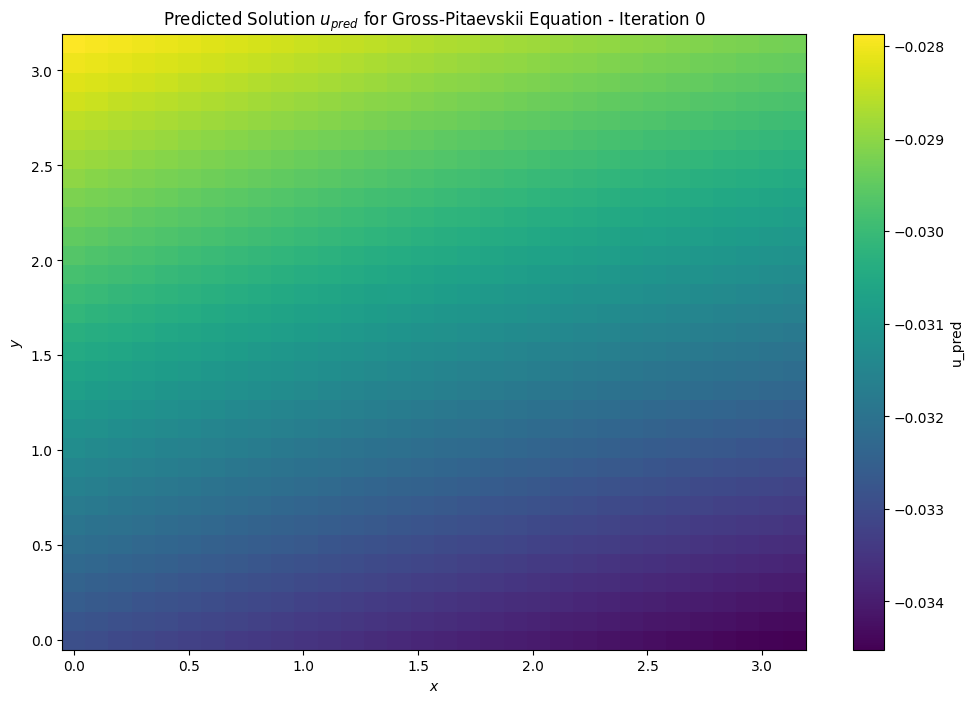

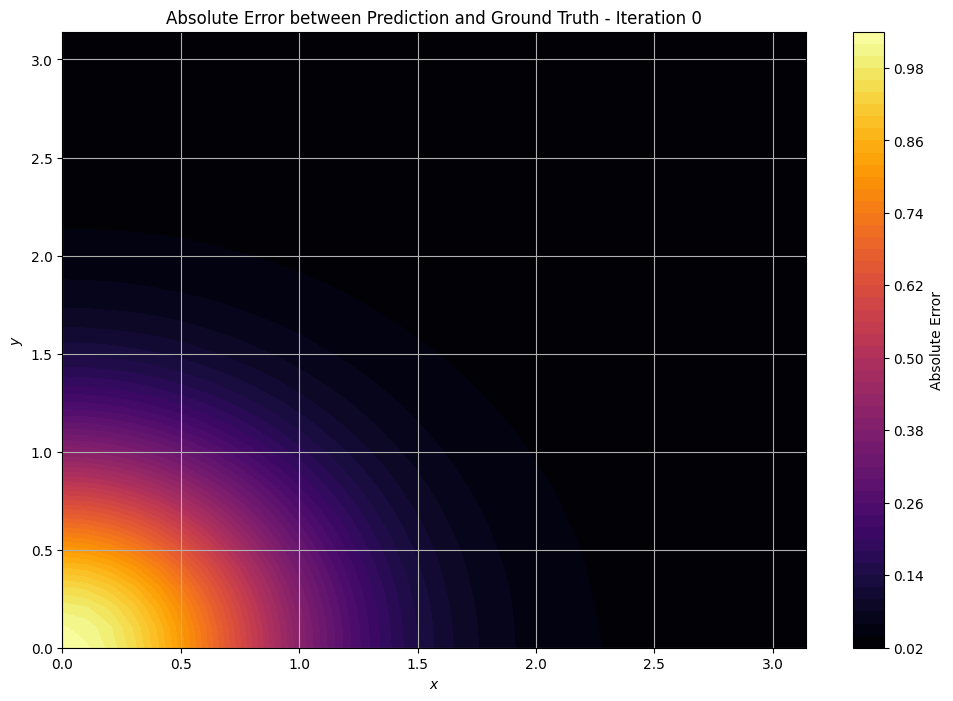

Epoch 0/500, Train Loss: 98.13066864


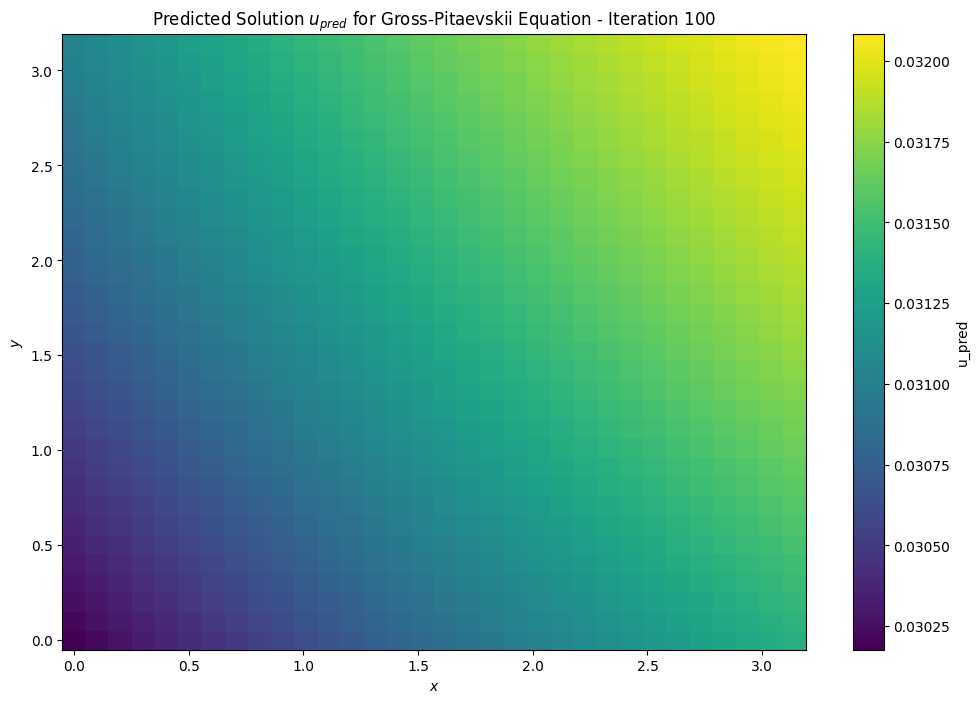

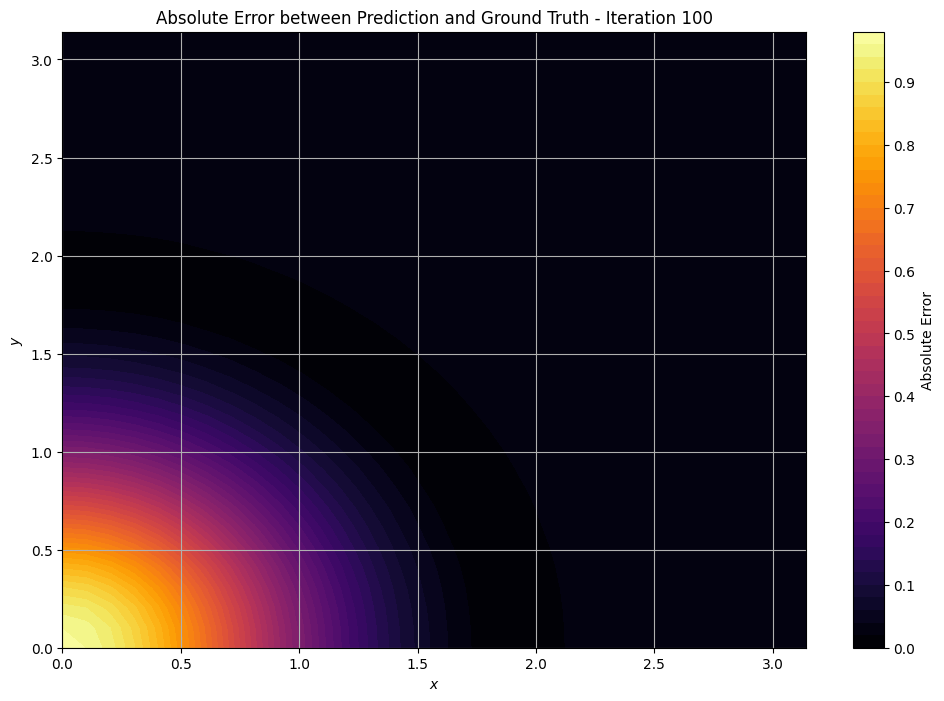

Epoch 100/500, Train Loss: 98.12914276


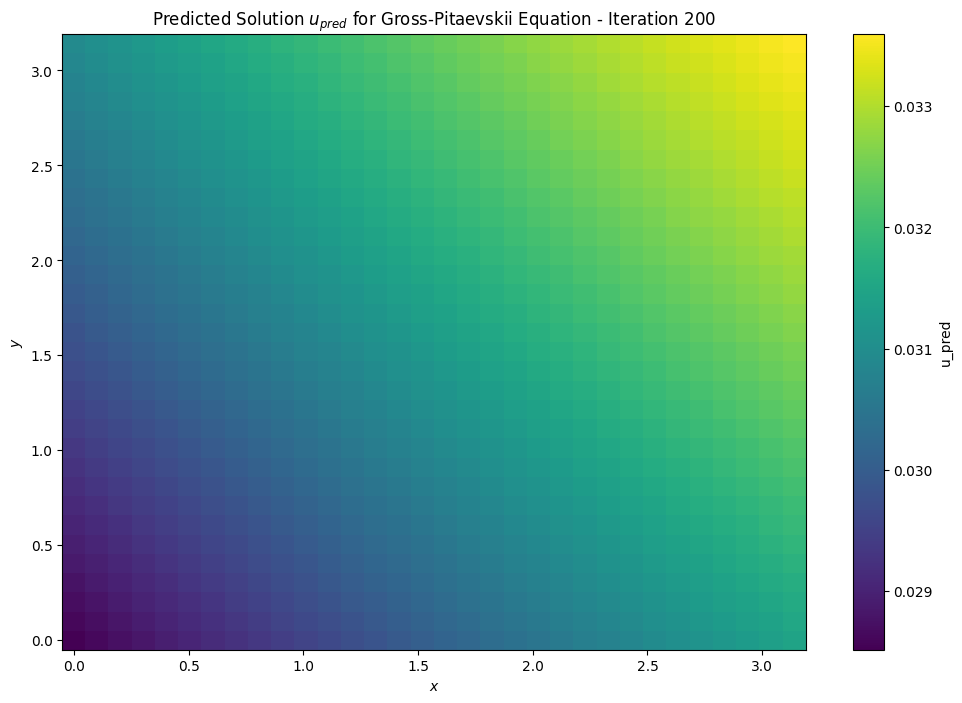

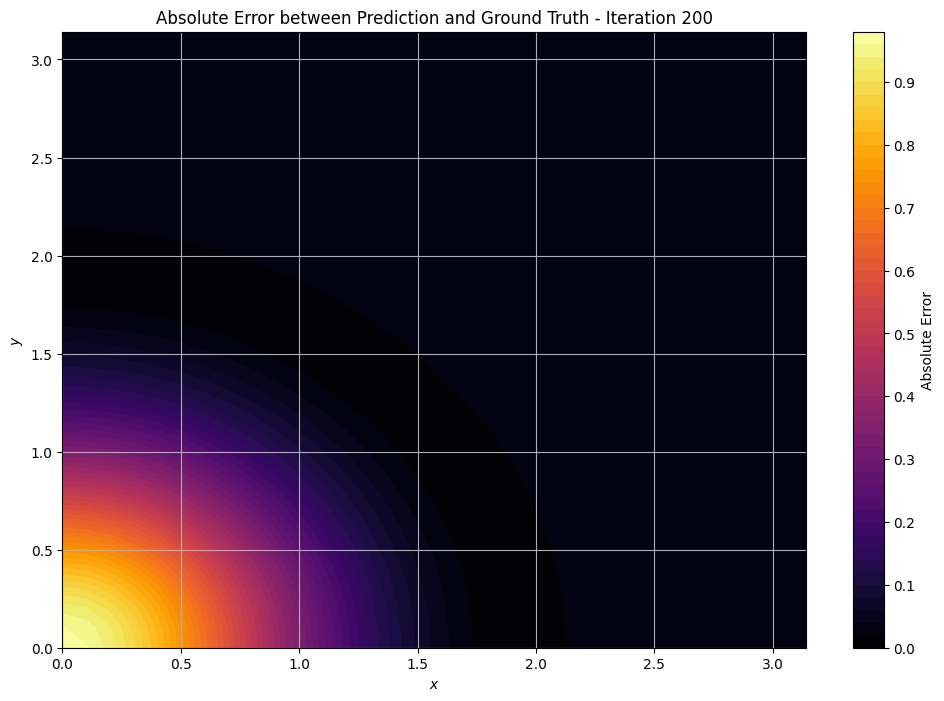

Epoch 200/500, Train Loss: 98.12816620


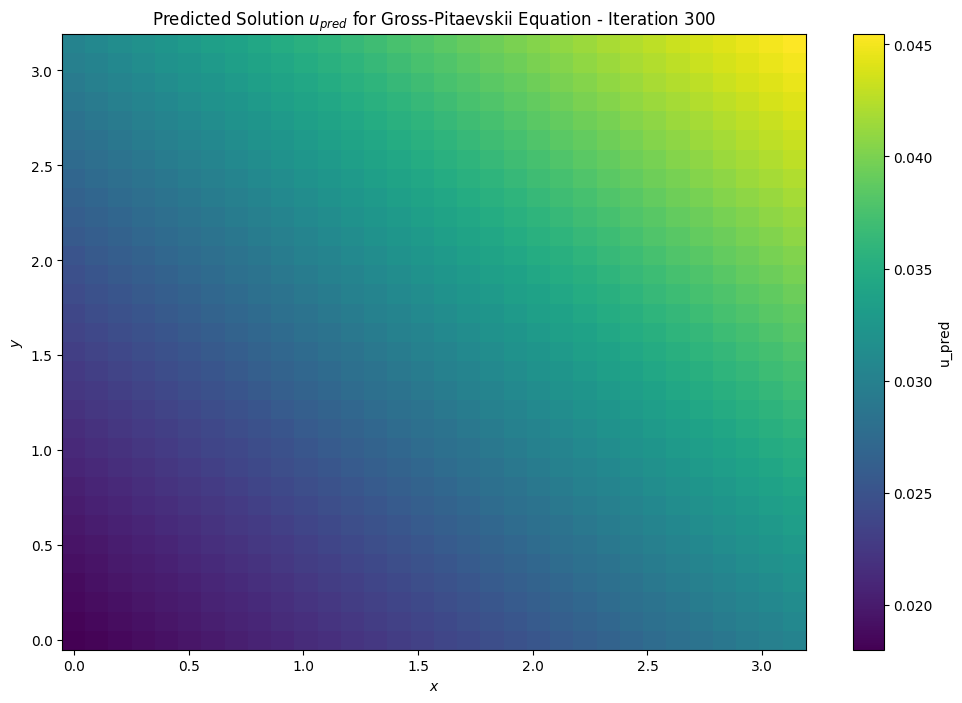

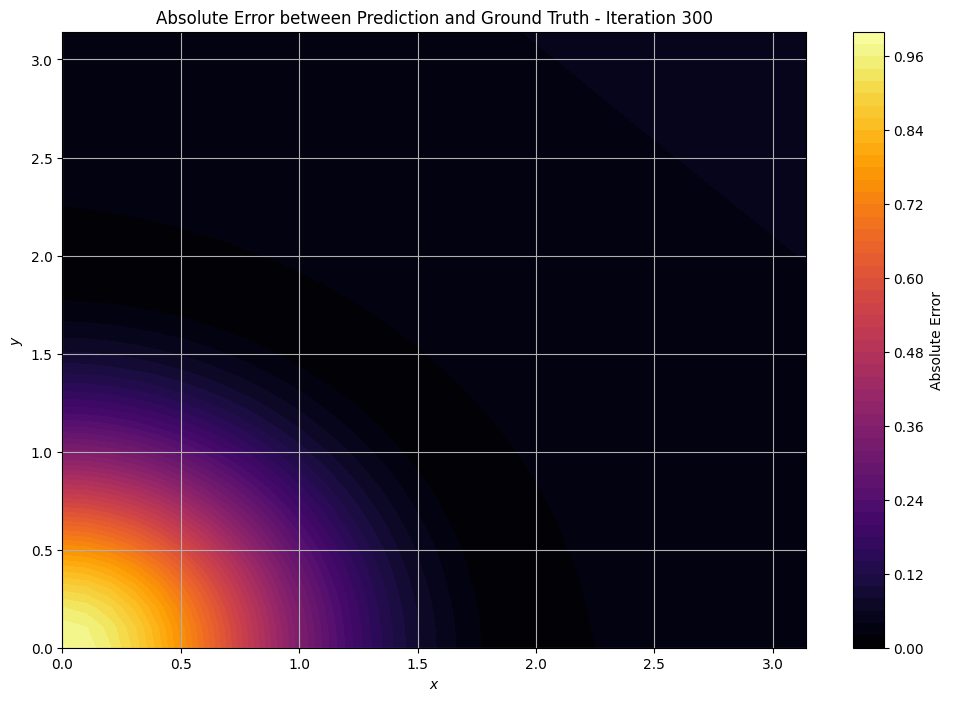

Epoch 300/500, Train Loss: 98.11405182


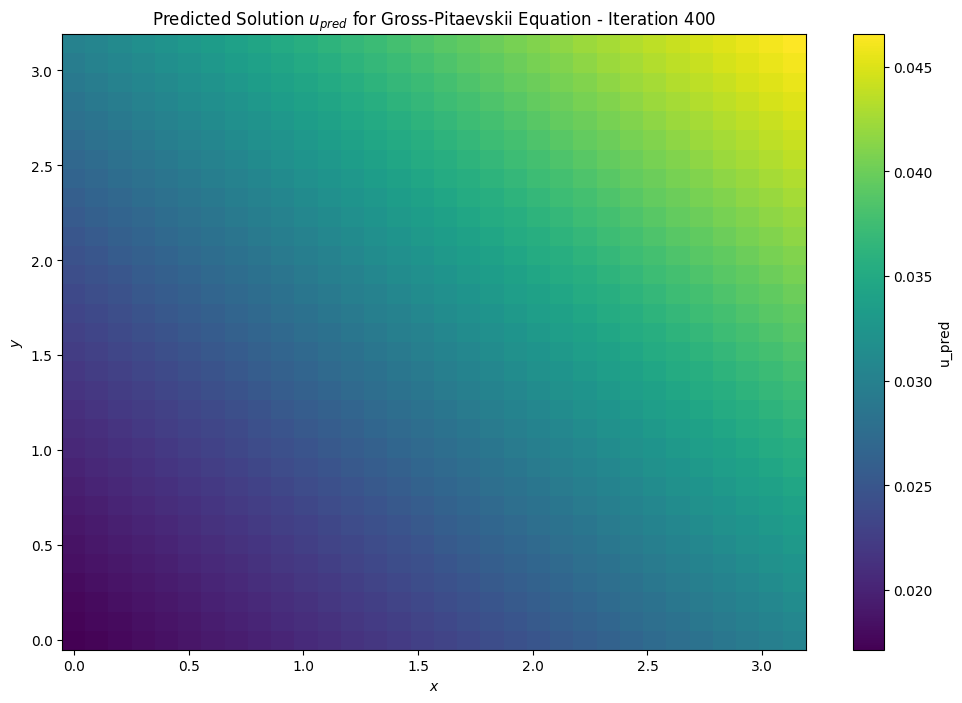

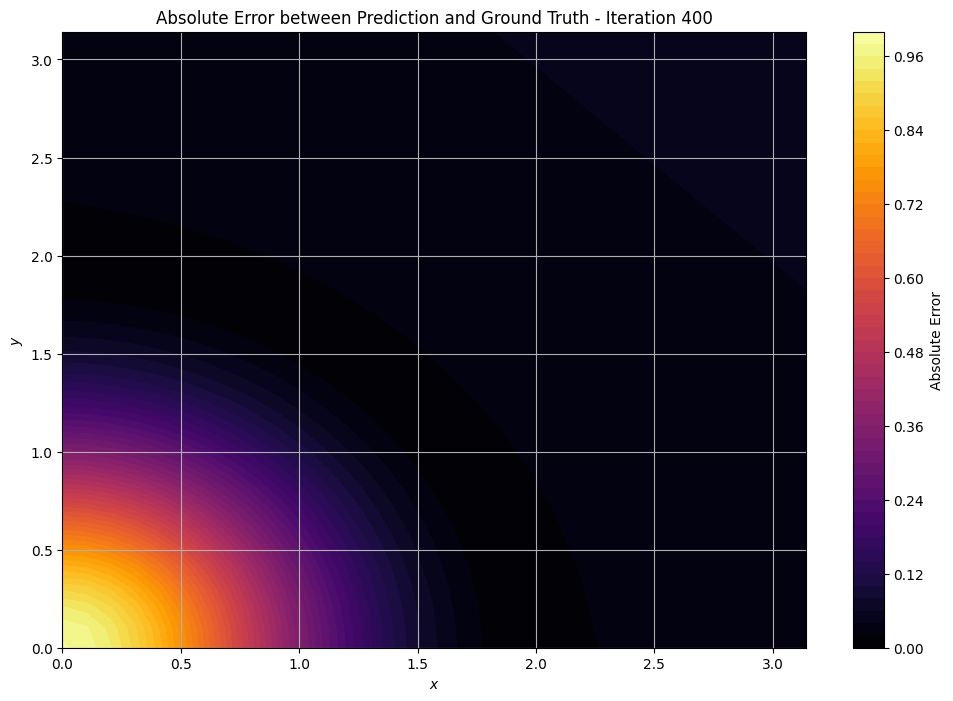

Epoch 400/500, Train Loss: 98.11347961


In [ ]:
# Specify number of grid points and number of dimensions
num_grid_pts = 32
nDim = 2

# Prepare test data
grids, axis_points = create_grid(num_grid_pts=num_grid_pts, n_dim=nDim)
X, Y = grids[0], grids[1]
x_1, x_2 = axis_points[0], axis_points[1]
X_u_test, lb, ub = prepare_test_data(X, Y)

N_u = 100  # Number of boundary points
N_f = 5000  # Number of collocation points
X_f_train_np_array, X_u_train_np_array, u_train_np_array = prepare_training_data(N_u, N_f, lb, ub, num_grid_pts, X, Y)

# Convert numpy arrays to PyTorch tensors and move to GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the GPE equation residual

# Model parameters
layers = [2, 256, 256, 256, 1]  # Neural network layers
epochs_adam = 500
epochs_lbfgs = 500

# Initialize the model
model = GrossPitaevskiiPINN(layers, ub=ub, lb=lb).to(device)

# Print the neural network architecture
print(model)

# Optimizers and scheduler
adam_optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-6,
                            amsgrad=False)
lbfgs_optimizer = optim.LBFGS(model.parameters(), max_iter=500, tolerance_grad=1e-5, tolerance_change=1e-9,
                              history_size=100)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, patience=200, factor=0.5, verbose=True)

# Train the model using the hybrid approach
train_pinn_hybrid(model, adam_optimizer, lbfgs_optimizer, scheduler, X_u_train, u_train, X_f_train, epochs_adam,epochs_lbfgs)

# Final test accuracy
pde_residual, u_pred = model.test(X_u_test_tensor)
#print(f'Test Error: {pde_residual:.5f}')

# Plot PDE Residual
#plot_pde_residual(model, X_u_test_tensor)

# Plot solution
#plot_solution(X_u_test_tensor.detach().cpu().numpy(), u_pred)

In [ ]:
# Final test accuracy
pde_residual, u_pred = model.test(X_u_test_tensor)

In [ ]:
# Plot PDE Residual
#plot_pde_residual(model, X_u_test_tensor)

In [ ]:
# Plot solution
#plot_solution(X_u_test_tensor.detach().cpu().numpy(), u_pred)